Calibrate camera

image read: calibration1.jpg (5, 9)


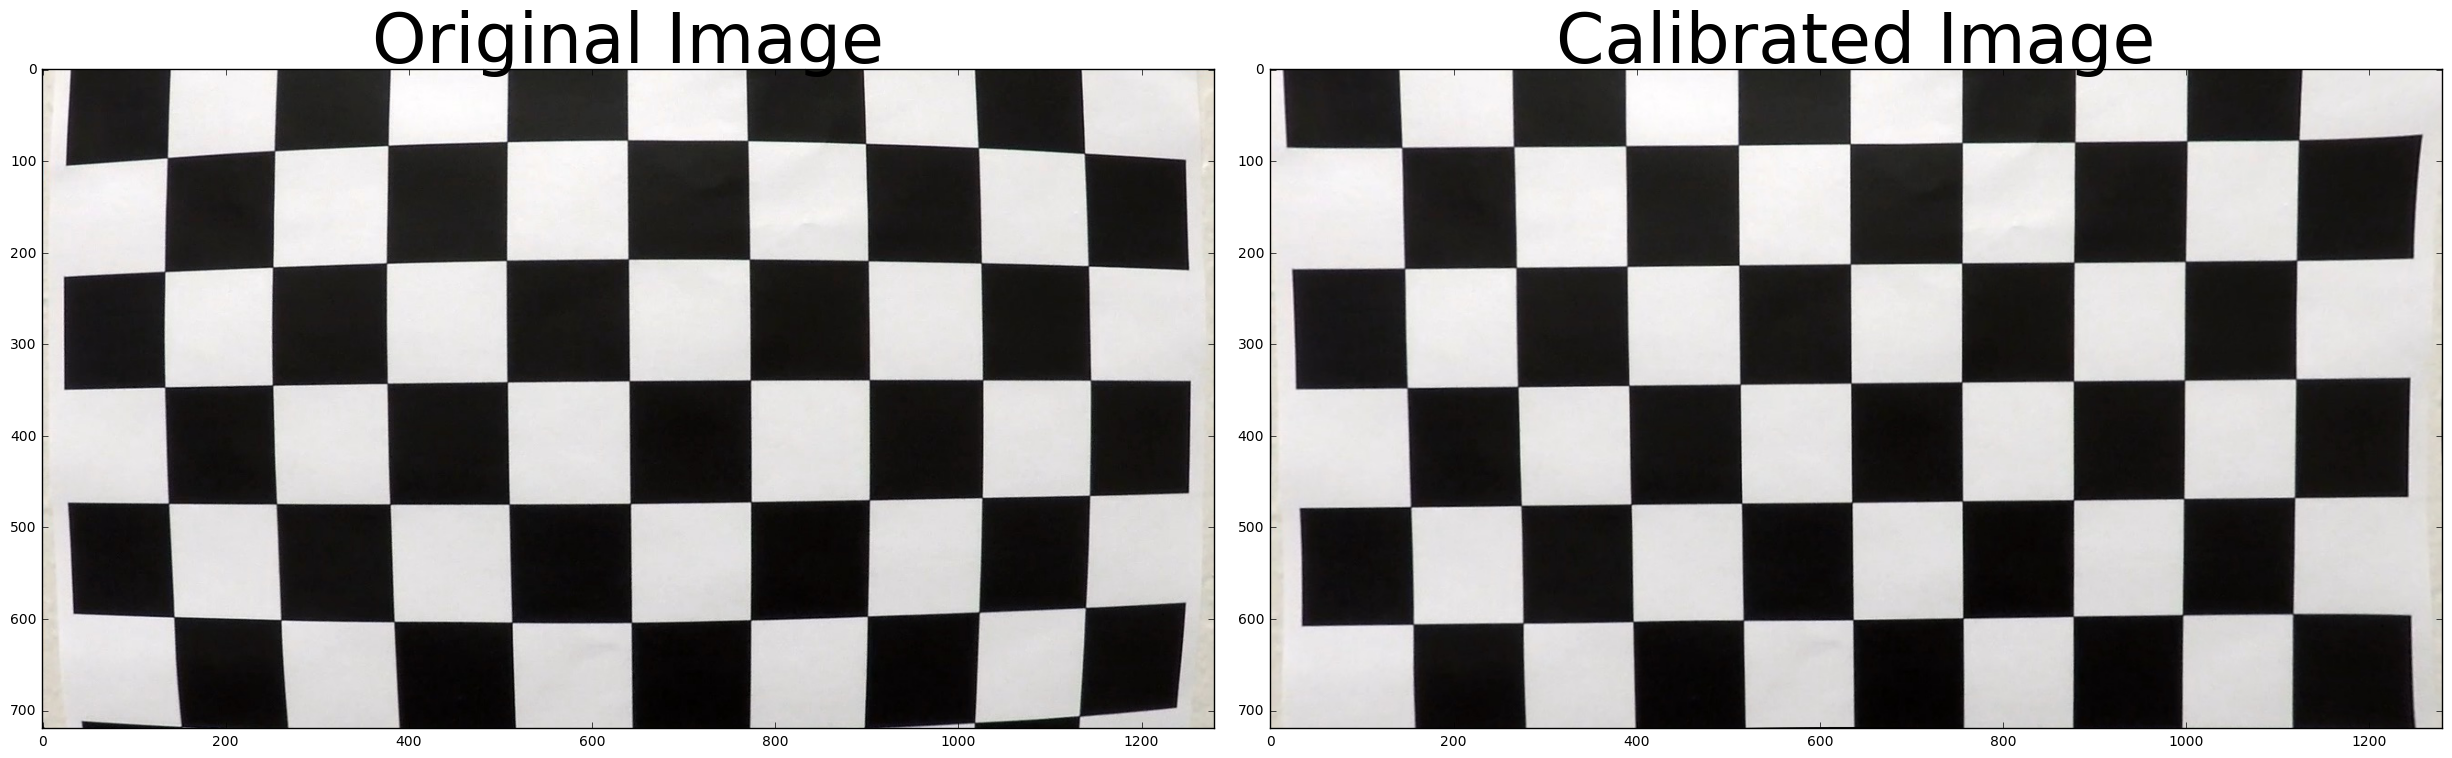

image skipped: calibration10.jpg
image skipped: calibration11.jpg
image skipped: calibration12.jpg
image skipped: calibration13.jpg
image skipped: calibration14.jpg
image skipped: calibration15.jpg
image skipped: calibration16.jpg
image skipped: calibration17.jpg
image skipped: calibration18.jpg
image skipped: calibration19.jpg
image read: calibration2.jpg (6, 9)


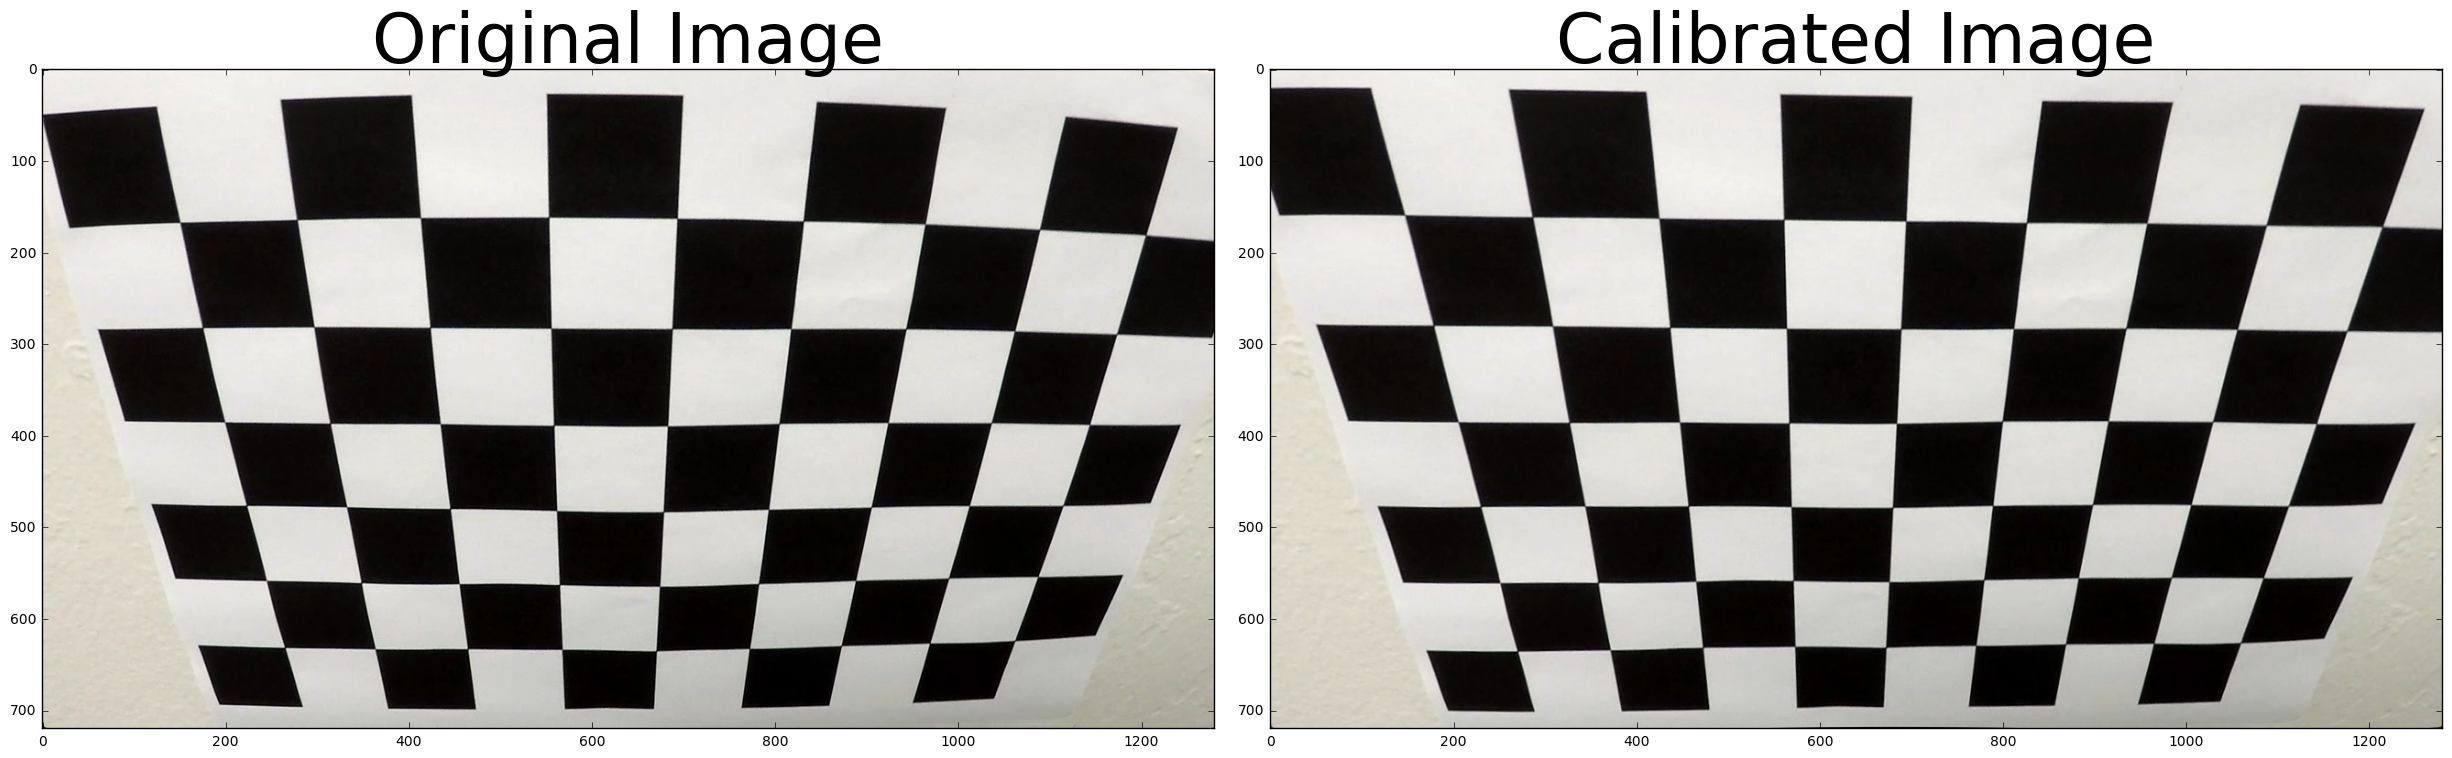

image skipped: calibration20.jpg
image skipped: calibration3.jpg
image skipped: calibration4.jpg
image skipped: calibration5.jpg
image skipped: calibration6.jpg
image skipped: calibration7.jpg
image skipped: calibration8.jpg
image skipped: calibration9.jpg
averaged mtx: [[  3.35533987e+03   0.00000000e+00   6.11212956e+02]
 [  0.00000000e+00   3.41730383e+03   2.69818623e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
averaged dist: [[-0.18908723  0.08998546  0.02315767  0.00219963  0.01551055]]


In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def calibrateImage(img, chessGrid):
    # 1) Convert to grayscale
  (nx, ny) = chessGrid 
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  mean = np.mean(gray)
  gray = (gray/mean*1.25).astype(np.uint8)*255     
    
    # 2) Find the chessboard corners
  # termination criteria
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

  ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None )

  if ret == True and not corners is None:
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)  

    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    objpoints.append(objp)
    
    corners2 = cv2.cornerSubPix(gray,corners,(30,30),(-1,-1),criteria)
    imgpoints.append(corners2)    
#    imgpoints.append(corners)
        
#    print(corners.shape)
    if ret == True:
      ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    # Undistort using mtx and dist
      h,  w = img.shape[:2]
      newcameramtx,roi =cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))
#      print(mtx,newcameramtx)
      undist = cv2.undistort(img, mtx, dist, None, newcameramtx)    
#      undist = cv2.undistort(img, mtx, dist, None, mtx)    
      return (mtx,dist,undist,newcameramtx)
  return (None,None,gray,None)


def showCalibrateImage(image,undist,mtx):

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(image)
  ax1.set_title('Original Image', fontsize=50)

  if mtx is None:
    ax2.imshow(undist,cmap="gray")
  else:
    ax2.imshow(undist)
    
  ax2.set_title('Calibrated Image', fontsize=50)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  #loop over the test pictures
  plt.show()


dict = {"calibration1.jpg":(5,9),
#        "calibration10.jpg":(6,9),
#        "calibration11.jpg":(6,9),
#        "calibration12.jpg":(6,9),
#        "calibration13.jpg":(6,9),
#        "calibration14.jpg":(6,9),
        "calibration15.jpg":(6,9),
#        "calibration16.jpg":(6,9),
#        "calibration17.jpg":(6,9),
#        "calibration18.jpg":(6,8),
 #       "calibration19.jpg":(6,9),
        "calibration2.jpg":(6,9)#,
#        "calibration20.jpg":(6,9),
#        "calibration3.jpg":(4,9),
#        "calibration4.jpg":(6,9),
        "calibration5.jpg":(5,9),
#        "calibration6.jpg":(6,9),
#        "calibration7.jpg":(6,9),
#        "calibration8.jpg":(6,9),
#        "calibration9.jpg":(6,9)
       }

avmtx = []
avdist = []
for item in os.listdir("camera_cal/"):
  path_to_image = os.path.join("camera_cal",item)
#  path_to_image = os.path.join("camera_cal",item)
  image = mpimg.imread(path_to_image) 
  if image is None:
    print("image not found",item)
    continue
    
  if item in dict:
    chessGrid = dict[item]
    print("image read:",item,chessGrid)
    mtx,dist,undist,newcameramtx = calibrateImage(image, chessGrid)
    if not mtx is None:
      avmtx.append(mtx)
      avdist.append(dist)
    showCalibrateImage(image,undist,mtx)#to show calibrated images
  else: 
    print("image skipped:",item)
    
mtx = np.mean(np.array(avmtx),axis=0)
dst = np.mean(np.array(avdist),axis=0)
print("averaged mtx:",mtx)
print("averaged dist:",dist)
    

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def color_select(image,threshold_r,threshold_g,threshold_b):
# Use a "bitwise OR" to identify pixels below the threshold
  thresholds = (image[:,:,0] < threshold_r) \
            | (image[:,:,1] < threshold_g) \
            | (image[:,:,2] < threshold_b)
  filtered = image.copy()
  filtered[thresholds] = [0,0,0]
  return filtered



In [3]:
from operator import itemgetter

#extract the lower center part of the image
def filterAreaOfInterest(image):
    maxx = image.shape[1]
    maxy = image.shape[0]
    y1 = int(maxy)
    y2 = int(maxy*0.58)
    x1 = int(maxx*0.4)
    x2 = int(maxx*0.6)
    x3 = int(maxx)
    area = np.array([[0,y1],[x1,y2],[x2,y2],[x3,y1]])
    
    return region_of_interest(image,[area])

#filter colors exeeding a statistical criteria
def filterImage(image):
    
  filtered_image = color_select(image,175,175,35)
  return filtered_image

#filter and average lines, add slope and offset
def averageLines(lines,max_delta_m, max_delta_b, max_delta_dist):
  av1_lines=[]
  av2_lines=[]
  for i in range(lines.shape[0]):
    for x1,y1,x2,y2 in lines[i]:
    
      if x2 -x1 == 0:
        continue
        
      #filter short lines
      l = (x2 -x1)*(x2 -x1) + (y2 - y1)*(y2 - y1)
      if l < 200:
        continue
    
      m1 = (y2 -y1) / (x2 -x1)
      if m1 == 0:
        m1 = 0.0001
        
      b1 = y1 - x1*m1
    
      #filter unrelistic angle to drive 
      if m1 > 0 and (m1 < 0.3 or  m1 > 2):
        continue
      elif m1 < 0 and (m1 > (-0.3) or  m1 < (-2)):
        continue
                     
      # sort coordinates
      if x2 > x1:
        av1_lines.append((m1,b1,x1,y1,x2,y2))  
      else:
        av1_lines.append((m1,b1,x2,y2,x1,y1))  
        
#loop over pairs of lines and collect similar ones to average        
  for i in range(len(av1_lines)):    
    (m1,b1,x11,y11,x12,y12) = av1_lines[i]
    if x11 == 0 and x12 == 0:
      continue
    av_lines=[]
    av_lines.append((m1,b1,x11,y11,x12,y12))  

    for j in range(len(av1_lines)-1, i, -1):
      (m2,b2,x21,y21,x22,y22) = av1_lines[j]
      if x21 == 0 and x22 == 0:
        continue
        
# distance between begin point and and point of two lines  
      dist = (x21 - x12)*(x21 - x12) + (y21 - y12)*(y21 - y12)
            
# apply average conditions
      if (abs(math.atan(m1) - math.atan(m2)) > max_delta_m) or (abs(b1 - b2) > max_delta_b) or dist > max_delta_dist:
        continue
        
      av_lines.append((m2,b2,x21,y21,x22,y22))  
# mark the line not to be used again  
      av1_lines[j] = (0,0,0,0,0,0)
#      print("merge ",j, " to ",i)

    if len(av_lines) > 1:
#mean for slope and offset
      av = np.mean(av_lines,axis=0)       
#min y for end of lane coordinate, 
      avmin = np.min(av_lines,axis=0)       
#max y for bottom line      
      avmax = np.max(av_lines,axis=0)       
      m = av[0]
      if m == 0:
        continue
        
      b = av[1]       

      x0 = avmin[2]        
      y0 = int(x0*m + b)      
    
      x1 = avmax[4]        
      y1 = int(x1*m + b)      
       
      av_line = (m,b,int(x0),int(y0),int(x1),int(y1))
      av2_lines.append(av_line)
    else:
      av2_lines.append(av_lines[0])    
    
  return av2_lines

#extend a line to the bottom ( max y value)
def extendToBottomTop(line, maxY, minY, centerX):
  (m,b,x1,y1,x2,y2) = line
#  print(line)
  yb = maxY
  xb = int((yb - b) / m)       

  yt = min(y1,y2)
  if minY > 0:
    yt = minY
    
  yt = minY
  xt = int((yt - b) / m)
    
# no cross of lines, so stop at the crossing of both
#left case
  if centerX != None and m < 0 and x2 > centerX:   
    xt = centerX
    yt = int(xt * m + b )
#right case
  if  centerX != None and m > 0 and x1 < centerX:   
    xt = centerX
    yt = int(xt * m + b )

  if y1 < y2:    
    return (m,b,xt,yt,xb,yb)
  else:
    return (m,b,xb,yb,xt,yt)
      
#select the first left and the last right and extend them  down to the bottom
def extendLines(lines, maxy,maxx,smooth):
  ext_lines = []
#extend to the bottom  
  for i in range(len(lines)):
    (m,b,x1,y1,x2,y2) = lines[i]
    yb = maxy
    xb = (yb - b) / m
                       
    line = (m,b,int(x1),int(y1),x2,y2)
    ext_lines.append(line)

#sort for the x at bottom and find a left and a right line close to the center
  left_line = None
  right_line = None
  ls = sorted(ext_lines,key=itemgetter(2))
    
# find the nicest left and right line
  for line in ls:
    (m,b,x1,y1,x2,y2) = line
    #left start in the left half and end close to the middle
    if m < 0 and x1 < maxx*0.5 and x2 < maxx*0.6 and left_line == None:
      left_line = line
    #right starts in the right half and end close to the middle
    elif m > 0 and x1 > maxx*0.4 and x2 > maxx*0.5:
      right_line = line
  
  ext2_lines = []
  #average y of the both lines to smooth it a bit
  minY = 0
  centerX = 0
  if left_line != None and right_line != None:
    (m,b,x1,y1,x2,y2) = left_line
    centerX = x2*0.5
    minY = y2*0.5
    (m,b,x1,y1,x2,y2) = right_line
    minY += y1*0.5
    centerX += x1*0.5
       
#smooth extend and smooth left line if available, othervise take the history
  if left_line != None:
    line = extendToBottomTop(left_line,maxy,int(minY),int(centerX))
    if smooth:
      line = smoothing(line,True)
    ext2_lines.append(line)
  elif smooth:
    line = smoothing(None,True)
    ext2_lines.append(line)

#smooth extend and smooth right line if available, othervise take the history
  if right_line != None:
    line = extendToBottomTop(right_line,maxy,int(minY),int(centerX))
    if smooth:
      line = smoothing(line,False)
    ext2_lines.append(line)
  elif smooth:
    line = smoothing(None,False)
    ext2_lines.append(line)
    
  return ext2_lines

#for logging bad situations
def saveImageAndReturn(image, name, image_counter):
  fig = plt.gcf()
  plt.imshow(image)
  imageName = "{0}{1}".format(name,image_counter)
  fig.savefig(imageName) 
  print("stored image:",imageName)
  return image       

#draw lines
def drawLines(lines,lines_img):
    for line in lines:
      (m,b,x1,y1,x2,y2) = line
      cv2.line(lines_img, (x1,y1), (x2,y2), [255,0,0], 15)

        
#canny using auto adjusted thresholds as described here
#http://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
def autoCanny(image, sigma=0.33):
#compute the median of the single channel pixel intensities
  v = np.median(image)
 
# apply automatic Canny edge detection using the computed median
  lower = int(max(0, (1.0 - sigma) * v))
  upper = int(min(255, (1.0 + sigma) * v))
  return cv2.Canny(image, lower, upper)   

def smoothOneLine(line,history):
  hisSize = 10
# if we have a new line check it and update the history 
  if line != None:
    (m,b,x1,y1,x2,y2) = (line)   
    if len(history) == hisSize:
      his =  np.mean(history,axis=0)
      (mh,bh,xh1,yh1,xh2,yh2) = (his)   

# use line only if it is similar to history
      if (abs(math.atan(m) - math.atan(mh)) < 0.1):        
# update history
        history.pop()
        history.insert(0,line)
    else: 
      history.insert(0,line)
    
#smooth only after the history is available  
  if len(history) == hisSize:
    smoothed =  np.mean(history,axis=0)
    (m,b,x1,y1,x2,y2) = (smoothed)   
            
    return ((m,b,int(x1),int(y1),int(x2),int(y2)))
  else:
    return line
      
    
#historic list for left and right lines
global lhistory,rhistory
lhistory = []
rhistory = []

#smooth left or right line using a list of historic values, 
#cap the min y value close to the center
def smoothing(line,isLeft):
  global lhistory
  global rhistory

# update history left and right
  if isLeft:
    return smoothOneLine(line,lhistory)
  else:
    return smoothOneLine(line,rhistory)

In [4]:
import math
from scipy.ndimage.interpolation import shift

def mag_threshold(gray, sobel_kernel=9, thresh=(0, 255)):
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    
    gradmag = (gradmag/scale_factor).astype(np.uint8)     
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def dir_threshold(gray, sobel_kernel=9, thresh=(0, 90)):
    lt = thresh[0]/180*np.pi
    ut = thresh[1]/180*np.pi
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    at = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    atbinary = np.zeros_like(gray)

    atbinary[(at >= lt) & (at <= ut)] = 1
    
    return atbinary

#binary from color thresholds on each color channel
def binaryWhite(image,thresh):
# Use a "bitwise OR" to identify pixels below the threshold
  threshold_r,threshold_g,threshold_b = (thresh)
  binary = np.zeros_like(image[:,:,0])
  binary[(image[:,:,0] >= threshold_r) \
            & (image[:,:,1] >= threshold_g) \
            & (image[:,:,2] >= threshold_b)]= 255
  return binary

#binary of S level between thresholds
def binarySfromHLS(image,thresh):
  hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
  S = hls[:,:,2]    
    
#  mag_binary = mag_threshold(S,thresh=(30,240))  
  binary = np.zeros_like(S)
#  binary[(S > thresh[0]) & (S <= thresh[1]) &  (mag_binary>0)] = 255    
  binary[(S > thresh[0]) & (S <= thresh[1])] = 255    
  return binary

#binary image combining S Level from HLS to get yellow lines and white from color space. Compined using "OR"
def binaryFromColorspace(image,threshS,threshW):
  c_binary = binaryWhite(image, threshW)
  s_binary = binarySfromHLS(image,threshS)
  binary = np.zeros_like(s_binary)
  binary[(c_binary > 0) | (s_binary > 0)] = 255    
  return binary
    
def combinedBinaryFromGradient(gray,mag_thresh,dir_tresh):
  dir_binary = dir_threshold(gray,thresh=dir_tresh)
  mag_binary = mag_threshold(gray,thresh=mag_thresh)

  combined = np.zeros_like(gray)
  dir_binary = np.zeros_like(gray)
  combined[((dir_binary > 0) | (mag_binary > 0))] = 255
  return combined

def transformPerspective(image,M):
  warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
  return warped
    
def getCameraPerspective(image,src,dst):
  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)  

  warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(image)
  ax1.set_title('Test Image to gain Perspective', fontsize=50)

  ax2.set_title('Transformed Image', fontsize=50)
  ax2.imshow(warped)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  plt.show()    
  return M,Minv
    
def filterOutliers(x,y):
  d = 0
  dx = []
  nx = len(x)
  for i in range(nx):
    if i > 0:
      d = (x[i]-x[i-1])/(y[i]-y[i-1])      
      dx.append(math.sqrt(d*d))
  dx = np.array(dx)
  md = max(dx)
  if md > 1:
    dx2 = dx[dx < md]
  else:
    dx2 = dx
  m = np.mean(dx2)
  std = np.std(dx2)
  xok = (dx[:] < (m + 1.5*std))
  print("dx:",dx)
  print("dx2:",dx2)
  print("<:",m+1.5*std)

  new_x = []
  new_y = []
  new_x.append(x[0])  
  new_y.append(y[0])
  #check first point
  if nx >= 3:
    if xok[0]:
      new_x.append(x[0])
      new_y.append(y[0])      
    elif not xok[1]:#second is the outlier
      new_x.append(x[0])
      new_y.append(y[0]) 
    else:
      print("skip 0")
        
    for i in range(len(xok)-1):
      if xok[i] or xok[i+1]:
        new_x.append(x[i+1])
        new_y.append(y[i+1])
      else:
        print("skip ",i+1)
        
    #check last point
    if xok[nx-2]:
      new_x.append(x[nx-1])
      new_y.append(y[nx-1])      
    elif not xok[nx-3]:#second last is the outlier
      new_x.append(x[nx-1])
      new_y.append(y[nx-1])      
    else:
      print("skip ",len(xok)-1)
        
  return np.array(new_x),np.array(new_y)

def findPeaks(image,isLeft):
  width = image.shape[1]
  height = image.shape[0]
  wh = int(width/2)
  hh = int(height/2)
    
  lr = range(wh,0,(-1))
  rr = range(wh,width)
    
  ly = []
  lx = []
  ry = []
  rx = []
#  if True:
  #find peak in the lower 100 pixel
  histogram = np.sum(image[image.shape[0]-100:image.shape[0],:], axis=0)      
  lc = int(np.argmax(histogram[0:wh]))
  rc = int(np.argmax(histogram[wh:]))+wh
#  print("peak:",lc,rc)
    
  offsetx = 150
  for i in range(16):
    to = height - int(height/20*i)
    f = height- int(height/20*(i+1))
    
    shifted = image[f:to,:]
    nshift=10
    histogram = np.sum(shifted, axis=0) 
    for i in range(nshift-1):
      shifted = shift(shifted.copy(),1,cval=0)
      histogram += np.sum(shifted, axis=0) 
        
    hi = histogram < 500
    histogram[hi] = 0

    lpeak = int(np.argmax(histogram[max(0,lc-offsetx):min(lc+offsetx,wh)])-nshift/2)
    rpeak = int(np.argmax(histogram[max(wh,rc-offsetx):min(rc+offsetx,width)])-nshift/2)
    
    y = int((f+to)/2)
    if lpeak > 0:
        ly.append(y)
        x=max(min(lpeak+lc-offsetx,wh),0)
        lx.append(x)
        if rpeak < 0:
          rc += (x-lc)    
          rx.append(rc)
          ry.append(y)
#          print("rc follows lc")
        lc = x
        
    if rpeak > 0:
        ry.append(y)
        x=max(min(rpeak+rc-offsetx,width),wh)
        rx.append(x)
        if lpeak < 0:
          lc += (x-rc)    
          lx.append(lc)
          ly.append(y)
#          print("lc follows rc")
        rc = x
#    print("search at:",lc,rc)

        
#  if len(ly) > 0:   
#    print("filter left")
#    lx,ly = filterOutliers(lx,ly)
#  if len(ry) > 0:   
#    print("filter right")
#    rx,ry = filterOutliers(rx,ry)
  return (lx,ly,rx,ry)
  
def fitSecondOrderPolynom(x,y,ymin,ymax):
  fit = np.polyfit(y, x, 2)
  y = np.insert(y,0,ymax)
  y = np.append(y,ymin)
  fitx = fit[0]*y**2 + fit[1]*y + fit[2]
  return (np.array(fitx),np.array(y))
    
def curveRad(x, y):  
# Define conversions in x and y from pixels space to meters
  ym_per_pix = 30/500 # meters per pixel in y dimension extracted from left dashed line in the transformed image (getCameraPerspective)
  xm_per_pix = 3.7/710 # meteres per pixel in x dimension extracted from distance between both lines in the transformed image (getCameraPerspective)

  fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
  y_eval = np.max(y)
  curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                             /np.absolute(2*fit_cr[0])
#  print(curverad)
  return int(curverad)
    
def drawLinesOnRoad(image,Minv,warped,lfx,ly,rfx,ry):

# Create an image to draw the lines on
  warp_zero = np.zeros_like(warped).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([lfx, ly]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([rfx, ry])))])
  pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
  result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
  return result  

def showBinaryAndWarped(binary,warped,lx,ly,rx,ry,lfx,lfy,rfx,rfy):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(binary,cmap="gray")
  ax1.set_title('color filter', fontsize=50)

  ax2.set_title('warped image', fontsize=50)
  ax2.imshow(warped,cmap="gray")
  ax2.plot(lx, ly, 'o', color='red')
  ax2.plot(rx, ry, 'o', color='blue')

  ax2.plot(lfx, lfy, 'o-', color='yellow')
  ax2.plot(rfx, rfy, 'o-', color='green')
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  plt.show()



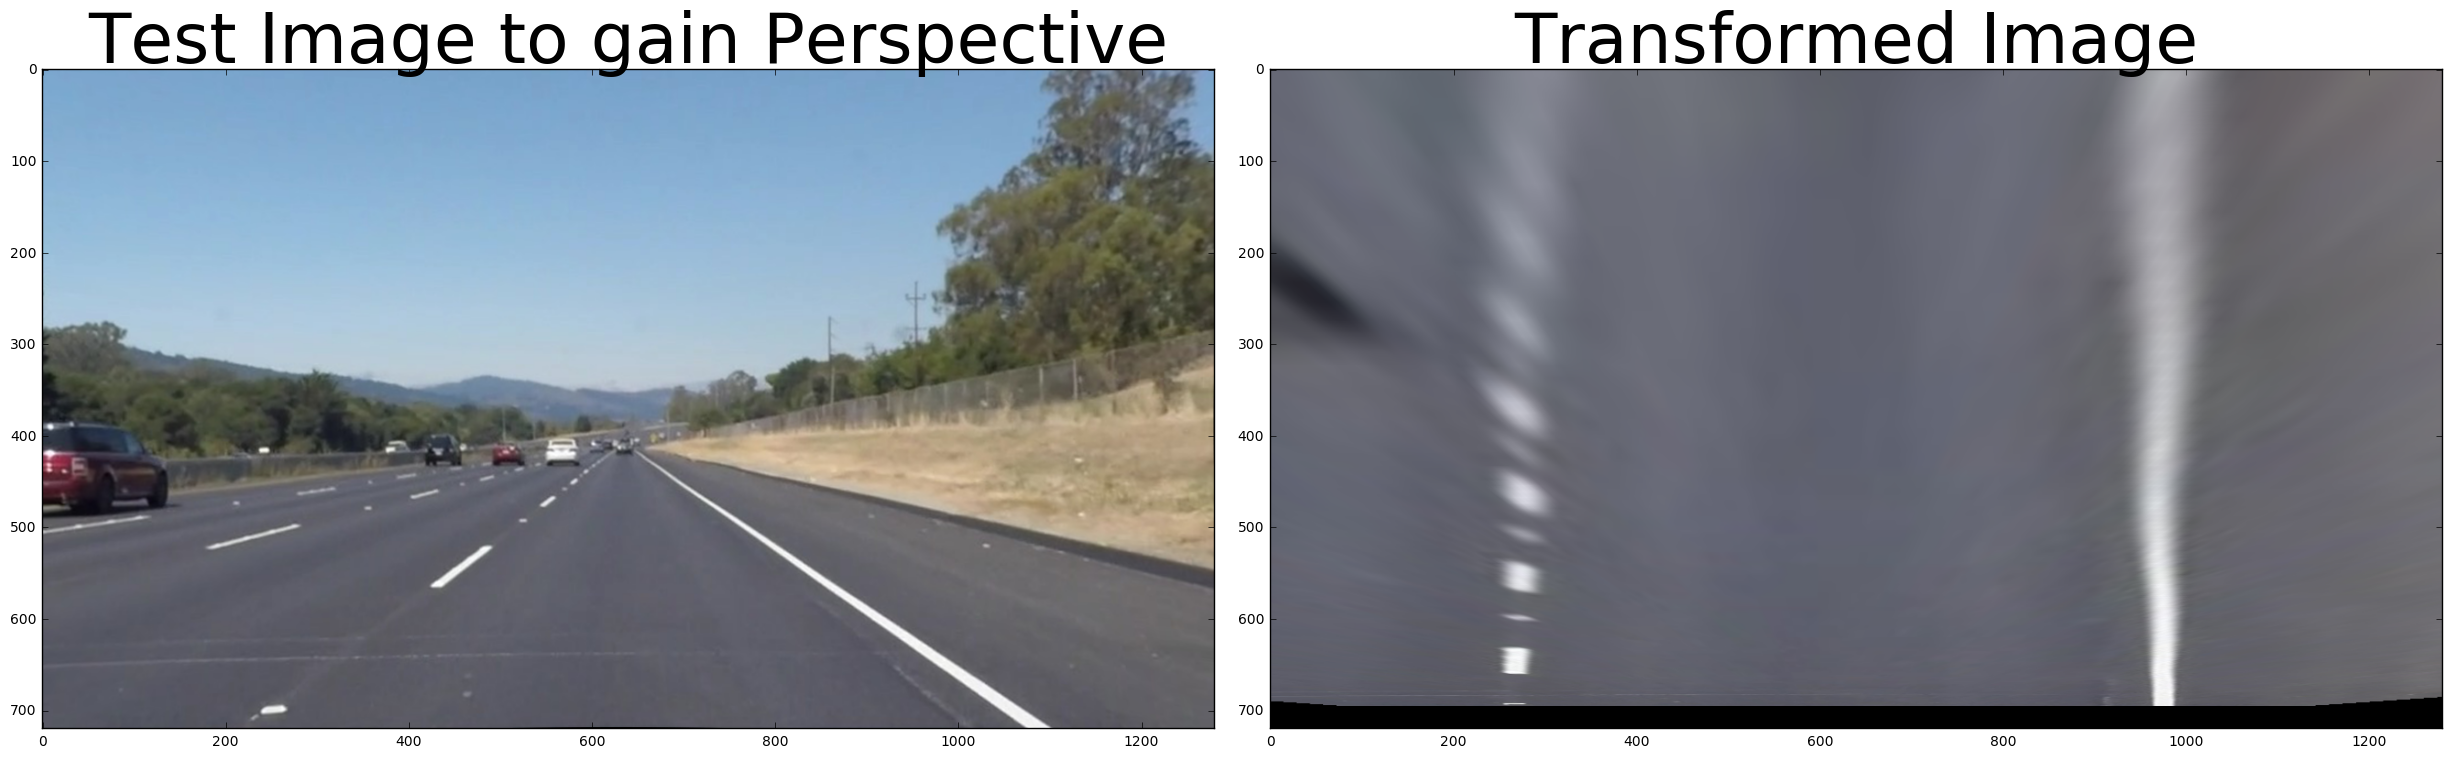

[[ -6.26871807e-01  -1.47175407e+00   9.98304363e+02]
 [ -1.59872116e-14  -1.79075401e+00   7.58928416e+02]
 [ -2.60208521e-17  -2.44802983e-03   1.00000000e+00]]


In [5]:
import scipy.misc
#calibrate camera
path_to_image = os.path.join("camera_cal","calibration1.jpg")
image = mpimg.imread(path_to_image) 
mtx,dist,undist,newcameramtx = calibrateImage(image, (5,9))

path_to_image = os.path.join("test_images","solidWhiteRight.jpg")
image = mpimg.imread(path_to_image)    
image = cv2.resize(image,(1280, 720), interpolation = cv2.INTER_CUBIC)
path_to_image = os.path.join("perspective_cal","solidWhiteRight1280_720.jpg")
scipy.misc.imsave(path_to_image, image)

src = np.float32([[ 300,692],[ 587,448],[ 1075,692],[ 695,448]])
dst = np.float32([[ 300,692],[ 300,448],[ 1000,692],[ 1000,448]])
image = cv2.undistort(image, mtx, dist, None, newcameramtx)    
#path_to_image = os.path.join("perspective_cal","testGerade1280_720_2_undist.jpg")
#scipy.misc.imsave(path_to_image, image)
#print(image.shape)
M,Minv = getCameraPerspective(image,src,dst)
print(M)


['solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'testGerade1280_720.JPG', 'testGerade1280_720_2.JPG']
solidYellowLeft.jpg
resize: (720, 1280, 3)


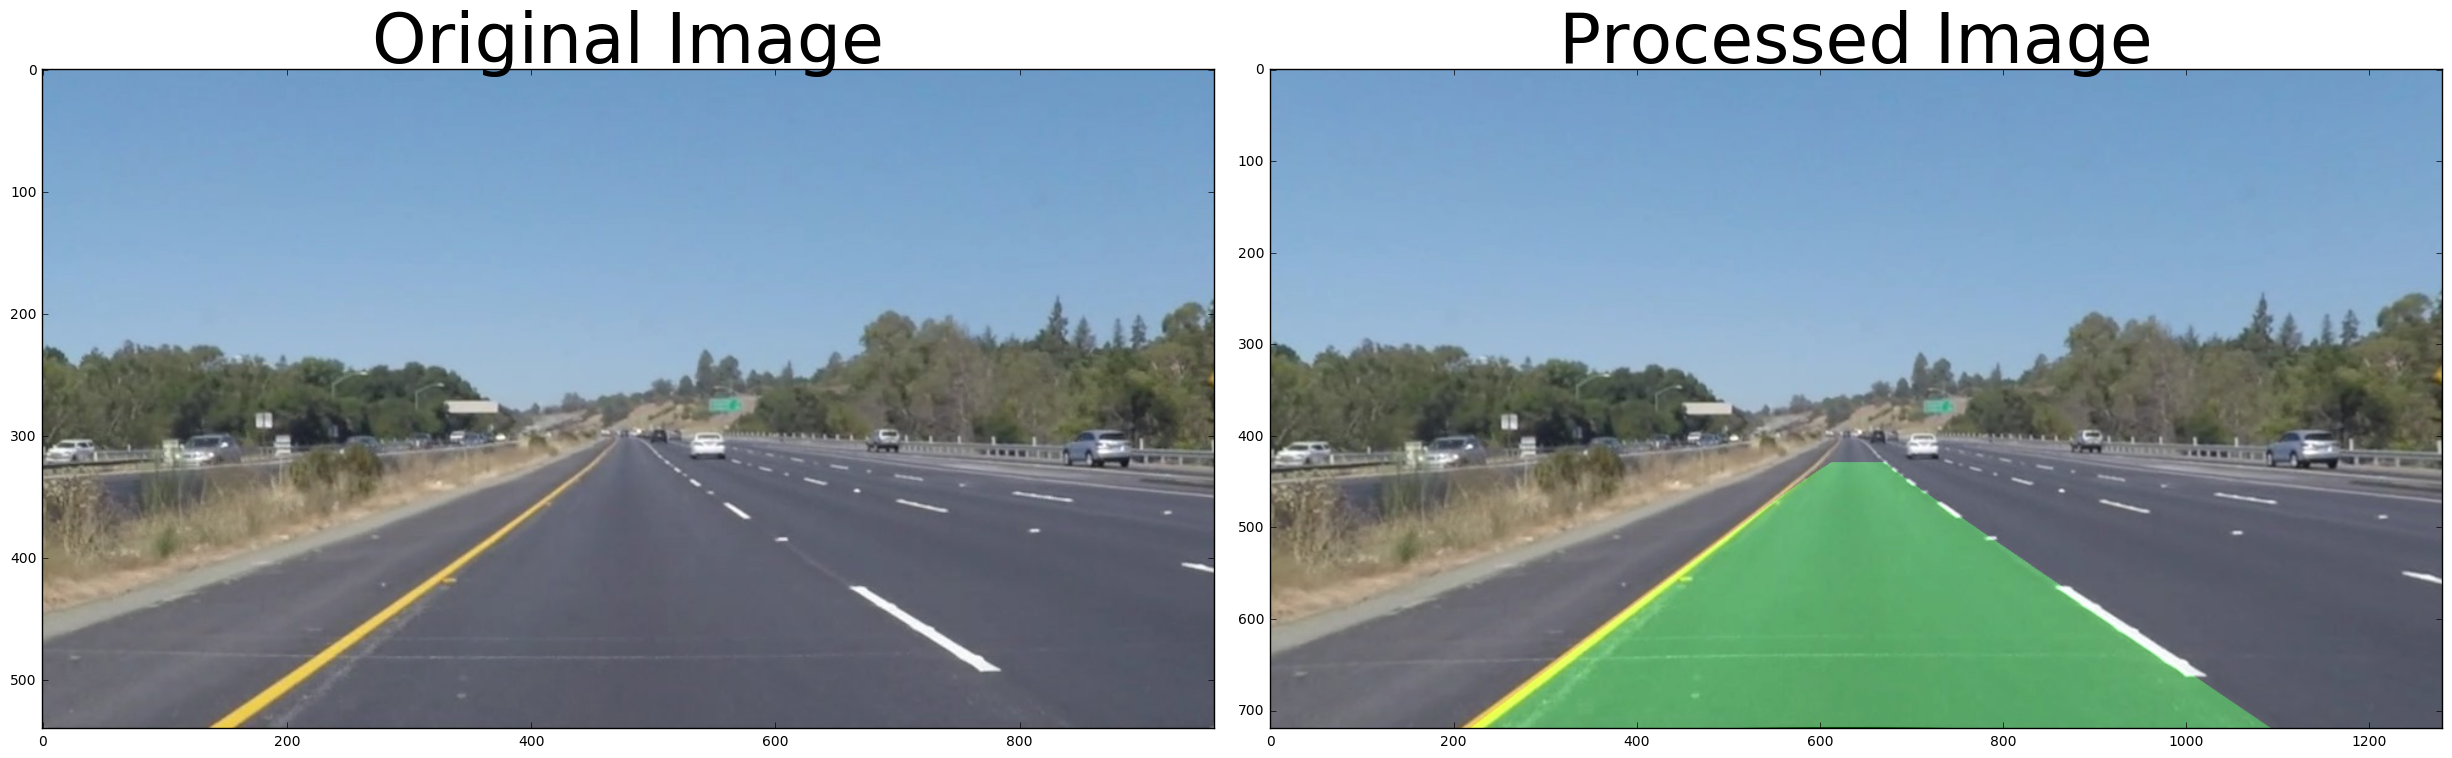

In [6]:
import os
print(os.listdir("test_images/"))

global bad_image_counter
bad_image_counter=0

#the process chain to draw lane lines on the road
def process_colored_image(image, mtx, dist, newcameramtx, M, Minv, smooth):
  global bad_image_counter

  if image.shape[0]!= 720 or image.shape[1]!= 1280:
    image = cv2.resize(image,(1280, 720), interpolation = cv2.INTER_CUBIC)
    print("resize:",image.shape)
  image = cv2.undistort(image, mtx, dist, None, newcameramtx)    

# apply an area of interest
  area_filtered_image = filterAreaOfInterest(image)
  warped = transformPerspective(area_filtered_image,M)

#  binary = binaryFromColorspace(warped,(80,255),(200,200,200))
  binary = binaryFromColorspace(warped,(150,250),(190,190,190))
# move to gray shaded
  gray = grayscale(warped)
#  combined = combinedBinaryFromGradient(gray,(80,200),(30,60))
  masked_image = cv2.bitwise_and(gray, binary)
    
#  plt.imshow(gray,cmap="gray")
#  plt.show()
#  plt.imshow(binary,cmap="gray")
#  plt.show()
#  plt.imshow(masked_image,cmap="gray")
#  plt.show()
    
#  warped = transformPerspective(masked_image,M)
  lfy = []
  rfy = []
  (lx,ly,rx,ry) = findPeaks(masked_image,True)
  ymax = max(np.max(ly),np.max(ry))
  ymin = min(np.min(ly),np.min(ry))
    
  if len(ly) > 2:
    (lfx,lfy) = fitSecondOrderPolynom(lx,ly,ymin,ymax)
  if len(ry) > 2:
    (rfx,rfy) = fitSecondOrderPolynom(rx,ry,ymin,ymax)
#  showBinaryAndWarped(binary,masked_image,lx,ly,rx,ry,lfx,lfy,rfx,rfy)
    
#  lcr = curveRad(lfx,lfy)
#  rcr = curveRad(rfx,rfy)
  if len(lfy) >=2 and len(rfy) >=2: 
    result = drawLinesOnRoad(image,Minv,masked_image,lfx,lfy,rfx,rfy)
  else:
    result = image
    
  return result


#loop over the test pictures
resultPath = "result_images/"
if not os.path.exists(resultPath):
  os.mkdir(resultPath)

if True:
  item = "solidYellowLeft.jpg"
#for item in os.listdir("test_images/"):
  #Read in and grayscale the image
  print(item)
  path_to_image = os.path.join("test_images",item)
  image = mpimg.imread(path_to_image)    
    
  result = process_colored_image(image, mtx, dist, newcameramtx, M, Minv, False)

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
  f.tight_layout()
  ax1.imshow(image)
  ax1.set_title('Original Image', fontsize=50)

  ax2.set_title('Processed Image', fontsize=50)
  ax2.imshow(result)
  plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  #loop over the test pictures

  path_to_result = os.path.join(resultPath,"result_{0}".format(item))
  fig = plt.gcf()
  fig.savefig(path_to_result) 
  plt.show()


In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import numpy as np

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return process_colored_image(image,mtx,dist,newcameramtx,M,Minv,False)

In [8]:
lhistory = []
rhistory = []
white_output = 'project_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

I:\Anaconda2\envs\py35\lib\site-packages\moviepy\audio\io\readers.py:110: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))



MoviePy: building video file project_result.mp4
----------------------------------------

Writing video into project_result.mp4
Done writing video in project_result.mp4 !
Your video is ready !
Wall time: 38min 30s
